# Proyek Klasifikasi Gambar: Garbage Dataset
- **Nama:** Muhammad Rizki Yanuar
- **Email:** mrizkiyanuar21@if.unjani.ac.id
- **ID Dicoding:** [MC381D5Y0681]

## Import Semua Packages/Library yang Digunakan

## Data Preparation

### **Import Library**

In [1]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import tqdm
from sklearn.utils.class_weight import compute_class_weight

#Library preprocessing gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.util import img_as_ubyte, random_noise

#Library Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import keras
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, GlobalAveragePooling2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Loading

### **Import Dataset dari Kaggle**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadrizkiyanuar","key":"cd44c62be468fbcf3bf1aaf4eddd6bda"}'}

In [3]:
!mkdir -p ~/.kaggle/

In [4]:
!cp /content/kaggle.json ~/.kaggle/

In [5]:
#Akses File
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d sumn2u/garbage-classification-v2

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT


In [7]:
!unzip /content/garbage-classification-v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage-dataset/paper/paper_847.jpg  
  inflating: garbage-dataset/paper/paper_848.jpg  
  inflating: garbage-dataset/paper/paper_849.jpg  
  inflating: garbage-dataset/paper/paper_851.jpg  
  inflating: garbage-dataset/paper/paper_852.jpg  
  inflating: garbage-dataset/paper/paper_853.jpg  
  inflating: garbage-dataset/paper/paper_855.jpg  
  inflating: garbage-dataset/paper/paper_856.jpg  
  inflating: garbage-dataset/paper/paper_857.jpg  
  inflating: garbage-dataset/paper/paper_859.jpg  
  inflating: garbage-dataset/paper/paper_861.jpg  
  inflating: garbage-dataset/paper/paper_863.jpg  
  inflating: garbage-dataset/paper/paper_865.jpg  
  inflating: garbage-dataset/paper/paper_868.jpg  
  inflating: garbage-dataset/paper/paper_870.jpg  
  inflating: garbage-dataset/paper/paper_871.jpg  
  inflating: garbage-dataset/paper/paper_873.jpg  
  inflating: garbage-dataset/paper/paper_874.jpg  
  inflating: garbage-dataset/pa

### **Buat Direktori dan Gabung Dataset**

In [8]:
#Direktori awal data
battery = "/content/garbage-dataset/battery"
biological = "/content/garbage-dataset/biological"
cardboard = "/content/garbage-dataset/cardboard"
clothes = "/content/garbage-dataset/clothes"
glass = "/content/garbage-dataset/glass"
metal = "/content/garbage-dataset/metal"
paper = "/content/garbage-dataset/paper"
plastic = "/content/garbage-dataset/plastic"
shoes = "/content/garbage-dataset/shoes"
trash = "/content/garbage-dataset/trash"

#direktori baru
combined = "Garbage/All_Data"

In [9]:
os.makedirs(combined, exist_ok=True)

In [10]:
#Copy file dan folder
all_direc = {
    'battery': battery,
    'biological': biological,
    'cardboard': cardboard,
    'clothes': clothes,
    'glass': glass,
    'metal': metal,
    'paper': paper,
    'plastic': plastic,
    'shoes': shoes,
    'trash': trash
    }

for category_name, category_path in all_direc.items():
  new_direc = os.path.join(combined, category_name)
  os.makedirs(new_direc, exist_ok=True)

  for filename in os.listdir(category_path):
    src_path = os.path.join(category_path, filename)
    dst_path = os.path.join(new_direc, filename)

    if not os.path.exists(dst_path):
      shutil.copy(src_path, dst_path)

### **Tampilkan Gambar, Labels, dan Resolusi**

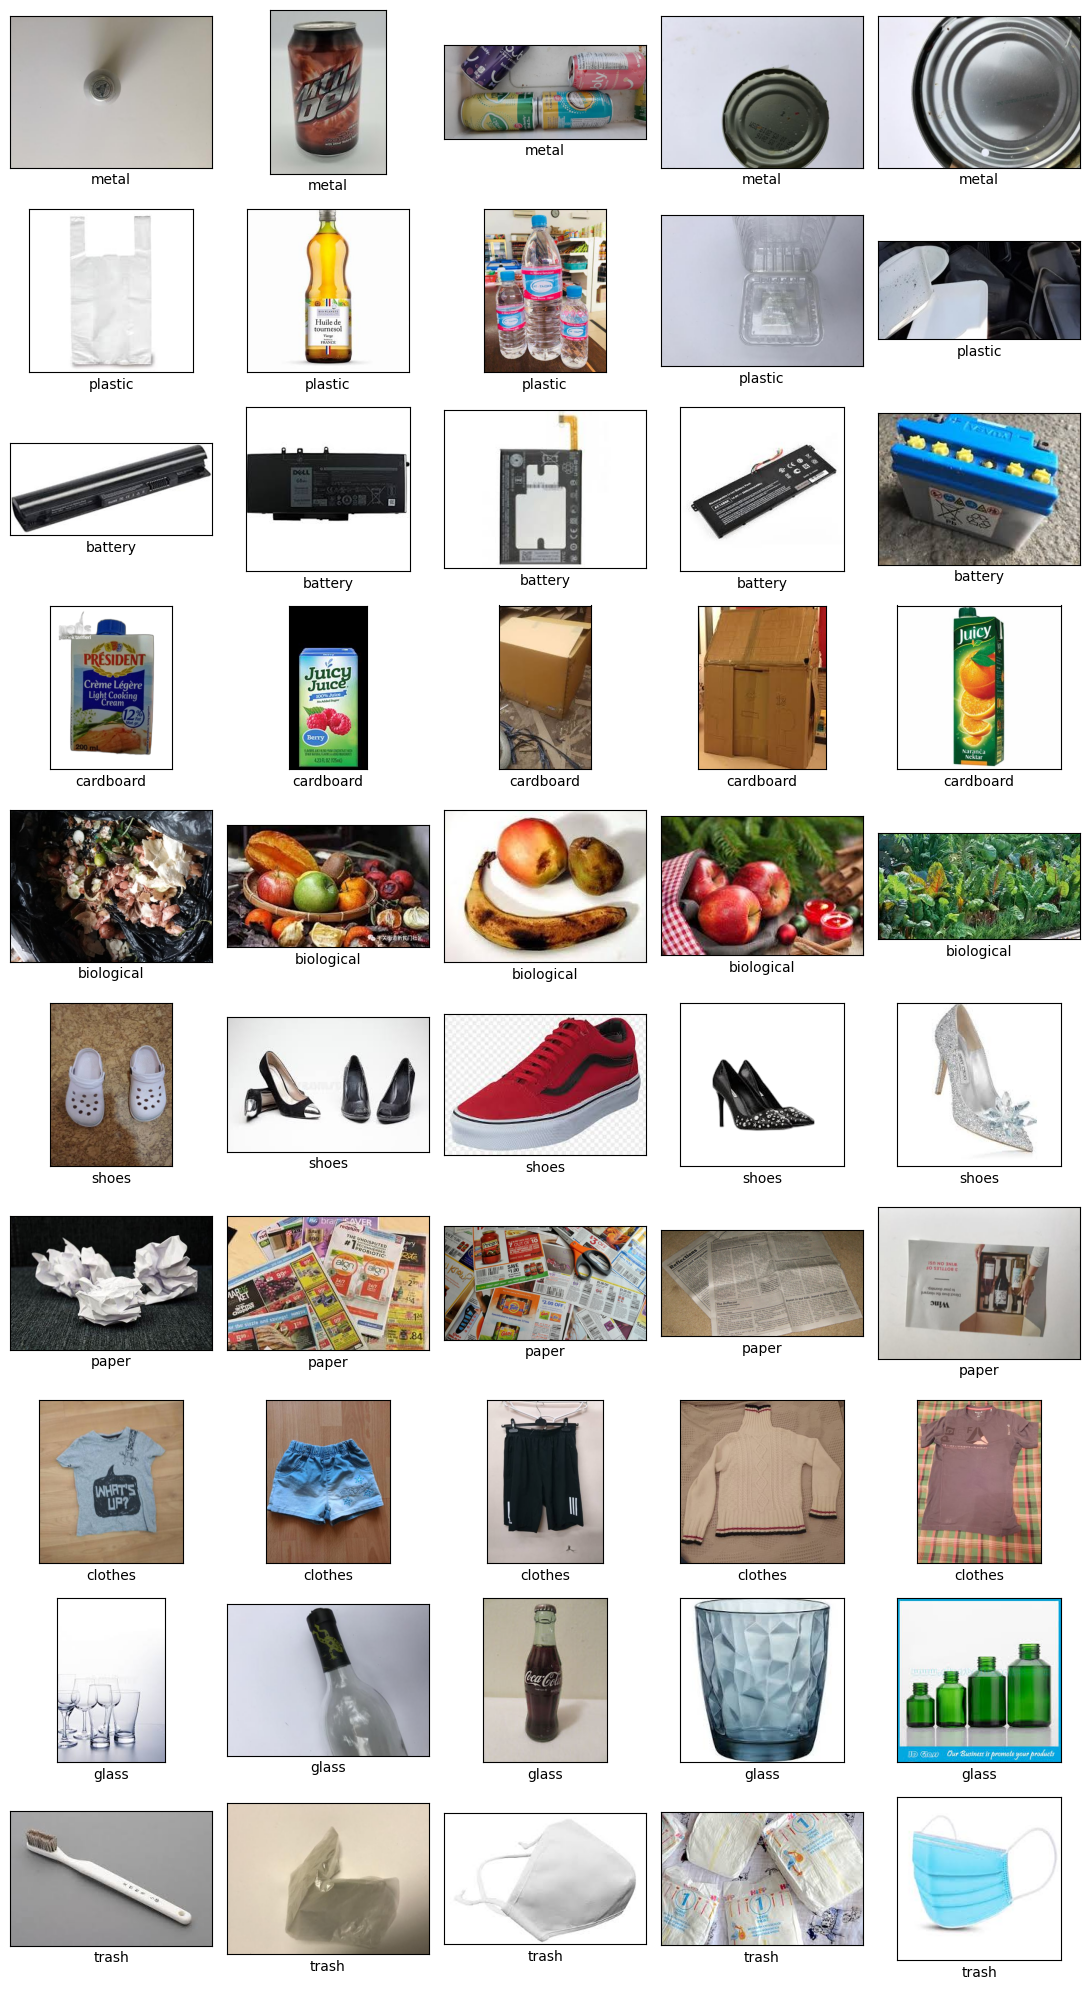

In [11]:
#Buat Variable menyimpan dictionary
garbage_img = {}

#cek isi folder
path = "/content/Garbage/"
path_sub = os.path.join(path, "All_Data")
for i in os.listdir(path_sub):
  garbage_img[i] = os.listdir(os.path.join(path_sub, i))

#Tampilkan 5 gambar secara random
path_sub = "/content/Garbage/All_Data"

fig, ax = plt.subplots(len(garbage_img.keys()), 5, figsize=(11,20))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(garbage_img[class_name], 5, replace=False)

  for j, img_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, img_name)
    img = Image.open(img_path)
    ax[i, j].imshow(img)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    ax[i, j].set(xlabel=class_name)

fig.tight_layout()

In [12]:
def print_img_reso(directory):
  unique_sizes = set()
  total_images = 0

  for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    img_files = os.listdir(subdir_path)
    print(f"{subdir}: {len(img_files)}")
    total_images += len(img_files)

    for img_file in img_files:
      img_path = os.path.join(subdir_path, img_file)
      with Image.open(img_path) as img:
        unique_sizes.add(img.size)

  print(f"Total images: {total_images}")
  print(f"Unique resolutions: {unique_sizes}")

print_img_reso(combined)

metal: 1020
plastic: 1984
battery: 944
cardboard: 1825
biological: 997
shoes: 1977
paper: 1680
clothes: 5327
glass: 3061
trash: 947
Total images: 19762
Unique resolutions: {(306, 304), (479, 412), (1001, 1620), (277, 277), (474, 971), (1200, 1600), (150, 322), (276, 318), (630, 401), (315, 160), (400, 613), (2968, 2984), (580, 580), (600, 787), (452, 394), (310, 310), (336, 448), (154, 328), (400, 469), (382, 600), (900, 1200), (474, 683), (550, 413), (200, 300), (334, 151), (280, 180), (320, 216), (390, 540), (69, 225), (257, 196), (141, 250), (599, 799), (1588, 1987), (654, 1000), (209, 241), (600, 800), (685, 1024), (2160, 2149), (1000, 770), (800, 416), (298, 169), (289, 349), (275, 451), (800, 1090), (400, 711), (475, 247), (400, 482), (352, 405), (4000, 3000), (370, 459), (475, 512), (248, 204), (428, 400), (474, 287), (302, 998), (231, 300), (250, 250), (405, 273), (350, 337), (264, 297), (474, 781), (548, 730), (2000, 1500), (662, 752), (728, 1600), (200, 169), (1500, 1442), (5

### **Plotting Distribusi Penyakit Kulit**

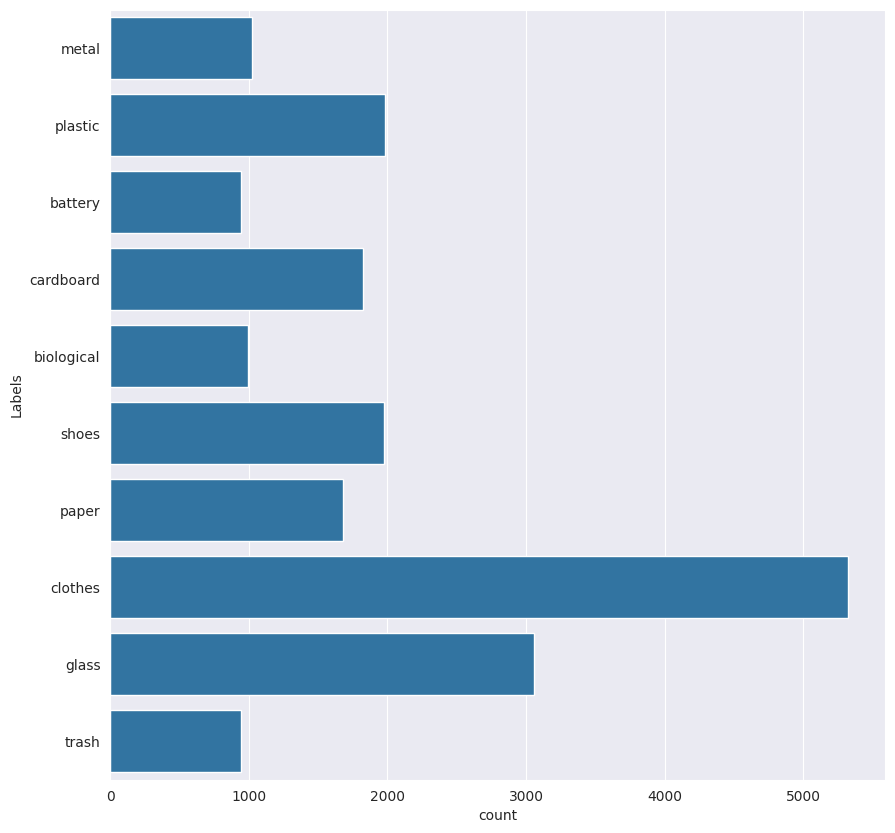

In [13]:
garbage_path = '/content/Garbage/All_Data'

#Daftar menyimpan data untuk setiap nama file, path_file, dan label
file_name = []
path_file = []
labels = []

#Ambil nama file, path_file, label dan simpan ke dataframe
for path, subdirs, files in os.walk(garbage_path):
  for name in files:
    path_file.append(os.path.join(path, name))
    file_name.append(name)
    labels.append(path.split('/')[-1])

distribution = pd.DataFrame({'File_name':file_name, 'Path':path_file, 'Labels':labels})

#plot distribusi gambar
Label = distribution['Labels']
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
sns.countplot(y=Label)
plt.xticks()
plt.show()

### Data Preprocessing

### **Data Augmentation**



In [14]:
# Augmentasi Functions
def to_tensor(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = img / 255.0
    return img

def to_numpy(img):
    img = img.numpy()
    img = np.clip(img, 0, 1)
    img = img_as_ubyte(img)
    return img

def clock_rotate(img):
    img = tf.image.rot90(img, k=1)
    return img

def anticlock_rotate(img):
    img = tf.image.rot90(img, k=3)
    return img

def flip_ud(img):
    img = tf.image.flip_up_down(img)
    return img

def flip_lr(img):
    img = tf.image.flip_left_right(img)
    return img

def gamma_adjust(img):
    gamma = random.uniform(0.5, 1.5)
    img = tf.image.adjust_gamma(img, gamma=gamma, gain=1)
    return img

def adjust_brightness(img):
    delta = random.uniform(-0.3, 0.3)  # Bisa lebih random
    img = tf.image.adjust_brightness(img, delta=delta)
    return img

def crop(img):
    img = tf.image.central_crop(img, central_fraction=0.7)
    img = tf.image.resize(img, (224, 224))
    return img

def sheared(img):
    # shear pakai numpy karena tf.image belum ada shear
    img = img.numpy()
    rows, cols, ch = img.shape
    shear_factor = random.uniform(-0.2, 0.2)
    M = np.array([[1, shear_factor, 0], [0, 1, 0]], dtype=np.float32)
    img = cv2.warpAffine(img, M, (cols, rows))
    img = img / 255.0
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    return img

In [15]:
# Dictionary Transformations
Transformation = {
    'clock_rotation': clock_rotate,
    'anticlock_rotation': anticlock_rotate,
    'flip_updown': flip_ud,
    'flip_leftright': flip_lr,
    'gamma': gamma_adjust,
    'brightness': adjust_brightness,
    'crop': crop,
    'sheared': sheared
}

# Path setup
images_path = '/content/Garbage/All_Data'
augmented_path = '/content/Garbage/Augmented_Data'

images = []

for imgs in os.listdir(images_path):
    folder_path = os.path.join(images_path, imgs)

    if os.path.isdir(folder_path):
        augmented_folder = os.path.join(augmented_path, imgs)
        os.makedirs(augmented_folder, exist_ok=True)
        print(f"Folder {augmented_folder} berhasil dibuat.")

        for filename in os.listdir(folder_path):
            if filename.endswith((".jpeg", ".png", ".jpg")):
                image_path = os.path.join(folder_path, filename)
                images.append((image_path, imgs))

# Augmentasi Generate
image_generate = 2500
i = 1

while i <= image_generate:
    image_choice, label = random.choice(images)
    try:
        original = io.imread(image_choice)

        if original.ndim not in [3]:
            raise ValueError('Invalid Dimension')

        img = to_tensor(original)
        num_augment = random.randint(1, 2)
        aug_keys = random.sample(list(Transformation.keys()), num_augment)

        for key in aug_keys:
            img = Transformation[key](img)

        img = tf.image.resize(img, (224, 224))
        img = to_numpy(img)

        new_image = os.path.join(augmented_path, label, f"augmented_image_{i}.jpg")
        cv2.imwrite(new_image, img)
        i += 1
    except Exception as e:
        print(f"Could not process {image_choice}: {e}")

Folder /content/Garbage/Augmented_Data/metal berhasil dibuat.
Folder /content/Garbage/Augmented_Data/plastic berhasil dibuat.
Folder /content/Garbage/Augmented_Data/battery berhasil dibuat.
Folder /content/Garbage/Augmented_Data/cardboard berhasil dibuat.
Folder /content/Garbage/Augmented_Data/biological berhasil dibuat.
Folder /content/Garbage/Augmented_Data/shoes berhasil dibuat.
Folder /content/Garbage/Augmented_Data/paper berhasil dibuat.
Folder /content/Garbage/Augmented_Data/clothes berhasil dibuat.
Folder /content/Garbage/Augmented_Data/glass berhasil dibuat.
Folder /content/Garbage/Augmented_Data/trash berhasil dibuat.


/usr/local/lib/python3.11/dist-packages/skimage/util/dtype.py:338: RuntimeWarning: invalid value encountered in cast
  return image_out.astype(dtype_out)
/usr/local/lib/python3.11/dist-packages/skimage/util/dtype.py:338: RuntimeWarning: invalid value encountered in cast
  return image_out.astype(dtype_out)
/usr/local/lib/python3.11/dist-packages/skimage/util/dtype.py:338: RuntimeWarning: invalid value encountered in cast
  return image_out.astype(dtype_out)
/usr/local/lib/python3.11/dist-packages/skimage/util/dtype.py:338: RuntimeWarning: invalid value encountered in cast
  return image_out.astype(dtype_out)
/usr/local/lib/python3.11/dist-packages/skimage/util/dtype.py:338: RuntimeWarning: invalid value encountered in cast
  return image_out.astype(dtype_out)
/usr/local/lib/python3.11/dist-packages/skimage/util/dtype.py:338: RuntimeWarning: invalid value encountered in cast
  return image_out.astype(dtype_out)


Could not process /content/Garbage/All_Data/paper/paper_2063.jpg: Invalid Dimension


/usr/local/lib/python3.11/dist-packages/skimage/util/dtype.py:338: RuntimeWarning: invalid value encountered in cast
  return image_out.astype(dtype_out)


In [16]:
#Gabung Data augmented ke folder All_Data
Augmen_Path = '/content/Garbage/Augmented_Data'
Ori_Path = '/content/Garbage/All_Data'

#Looping kategori pada path augmented
for category in os.listdir(Augmen_Path):
  augmented_folder = os.path.join(Augmen_Path, category)
  original_folder = os.path.join(Ori_Path, category)
  os.makedirs(original_folder, exist_ok=True)

  for filename in os.listdir(augmented_folder):
    src_path = os.path.join(augmented_folder, filename)
    dst_path = os.path.join(original_folder, filename)

  shutil.move(src_path, dst_path)

print("Augmented Data berhasil digabung")

Augmented Data berhasil digabung


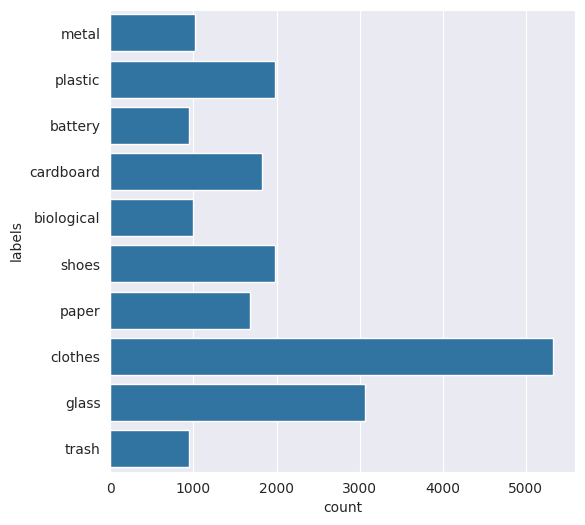

In [17]:
# Define source path
garbage_path = "/content/Garbage/All_Data/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(garbage_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [18]:
garbage_path = "/content/Garbage/All_Data/"

file_name = []
file_path = []
labels = []


for path, subdirs, files in os.walk(garbage_path):
    for name in files:
        file_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"image":file_name, "path":file_path, "labels":labels})

df.groupby(['labels']).size()

,0
labels,
battery,945
biological,998
cardboard,1826
clothes,5328
glass,3062
metal,1021
paper,1681
plastic,1985
shoes,1978


In [19]:
#Variable menyimpan data gambar dan label
X = df['path']
y = df['labels']

#Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

#Masukan kedalam masing-masing dataframe
df_train = pd.DataFrame({'path':X_train, "labels": y_train, "set":"train"})
df_test = pd.DataFrame({'path': X_test, "labels": y_test, "set":"test"})

print("print total data train: ", len(df_train))
print("print total data test: ", len(df_test))

print total data train:  15817
print total data test:  3955


In [20]:
#Gabung semua dataframe menjadi satu
df_all = pd.concat([df_train, df_test], ignore_index=True)

print(df_all.groupby(['set', 'labels']).size(), '\n')

set    labels    
test   battery        215
       biological     188
       cardboard      337
       clothes       1049
       glass          591
       metal          217
       paper          335
       plastic        431
       shoes          399
       trash          193
train  battery        730
       biological     810
       cardboard     1489
       clothes       4279
       glass         2471
       metal          804
       paper         1346
       plastic       1554
       shoes         1579
       trash          755
dtype: int64 



In [21]:
# Path dataset asli
path_datareal = "/content/Garbage/All_Data/"
# Path dataset gabungan train dan test
path_join = "/content/Garbage/TrainTest"

for index, row in tqdm.tqdm(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(path_datareal,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(path_join,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(path_join,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(path_join,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

19772it [00:06, 3024.26it/s]


In [22]:
# Directory for training data
Train_direc = "/content/Garbage/TrainTest/train/"
Test_direc = "/content/Garbage/TrainTest/test/"

#ImageGenerator object normalizing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

#Implementasi pada path train dan test
Train_generator = train_datagen.flow_from_directory(Train_direc,
                                                    target_size=(225, 225),
                                                    batch_size=42,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True
                                                    )

Validation_generator = train_datagen.flow_from_directory(Train_direc,
                                                        target_size=(225, 225),
                                                        batch_size=42,
                                                        class_mode='categorical',
                                                        subset='validation',
                                                        shuffle=False
                                                        )

Test_generator = test_datagen.flow_from_directory(Test_direc,
                                                  target_size=(225, 225),
                                                  batch_size=42,
                                                  class_mode='categorical',
                                                  shuffle=False
                                                  )

Found 12658 images belonging to 10 classes.
Found 3159 images belonging to 10 classes.
Found 3955 images belonging to 10 classes.


# Modelling

### **Model 1: CNN 32 Neurons & Adam Optimizers**

In [23]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(225,225,3))
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

<ipython-input-23-3ce957266df3>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(225,225,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [24]:
model1 = Sequential()

#Layers Convolusi
model1.add(base_model)

#Convo Layer
model1.add(Conv2D(64, (5,5), activation='relu', name='layer1'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

#GlobalPooling Layer
model1.add(GlobalAveragePooling2D())

#Dense Layer
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(10, activation='softmax')) #Output layer

model1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Conv2D)                 │ (None, 4, 4, 64)       │     2,048,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,323,530 (16.49 MB)

 Trainable params: 2,797,898 (10.67 MB)

 Non-trainable params: 1,525,632 (5.82 MB)

In [25]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('BestModel.h5', monitor='val_loss', save_best_only=True)

history1 = model1.fit(Train_generator,
                      validation_data=Validation_generator,
                      callbacks=[earlystop, checkpoint, reduce_lr],
                      epochs=10,
                      batch_size=42,
                      verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7144 - loss: 0.9053

302/302 ━━━━━━━━━━━━━━━━━━━━ 80s 211ms/step - accuracy: 0.7147 - loss: 0.9044 - val_accuracy: 0.8281 - val_loss: 0.7127 - learning_rate: 0.0010
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8765 - loss: 0.4078

302/302 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.8765 - loss: 0.4077 - val_accuracy: 0.8230 - val_loss: 0.6043 - learning_rate: 0.0010
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.8978 - loss: 0.3362 - val_accuracy: 0.7563 - val_loss: 0.9741 - learning_rate: 0.0010
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9083 - loss: 0.2899 - val_accuracy: 0.7809 - val_loss: 0.9087 - learning_rate: 0.0010
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9146 - loss: 0.2645 - val_accuracy: 0.8082 - val_loss: 0.8201 - learning_rate: 0.0010
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9401 - loss: 0.1933

302/302 ━━━━━━━━━━━━━━━━━━━━ 48s 160ms/step - accuracy: 0.9401 - loss: 0.1933 - val_accuracy: 0.8648 - val_loss: 0.4984 - learning_rate: 5.0000e-04
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9486 - loss: 0.1604

302/302 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9486 - loss: 0.1605 - val_accuracy: 0.8892 - val_loss: 0.4388 - learning_rate: 5.0000e-04
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9494 - loss: 0.1552

302/302 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - accuracy: 0.9494 - loss: 0.1552 - val_accuracy: 0.9003 - val_loss: 0.3926 - learning_rate: 5.0000e-04
Epoch 9/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9560 - loss: 0.1478

302/302 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9560 - loss: 0.1478 - val_accuracy: 0.9038 - val_loss: 0.3624 - learning_rate: 5.0000e-04
Epoch 10/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9550 - loss: 0.1391

302/302 ━━━━━━━━━━━━━━━━━━━━ 48s 160ms/step - accuracy: 0.9550 - loss: 0.1391 - val_accuracy: 0.9101 - val_loss: 0.3355 - learning_rate: 5.0000e-04


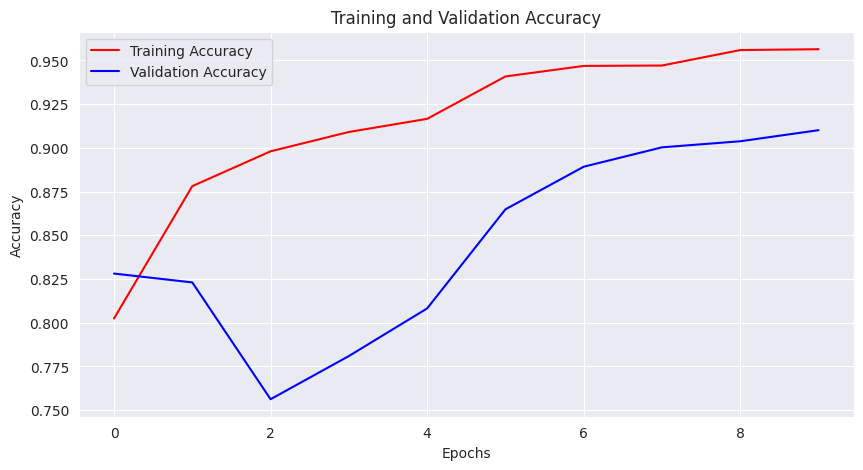

In [26]:
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

## Evaluasi dan Visualisasi

95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9416 - loss: 0.2033
Test Loss: 0.2892482876777649, Test Acc: 0.922123908996582
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step


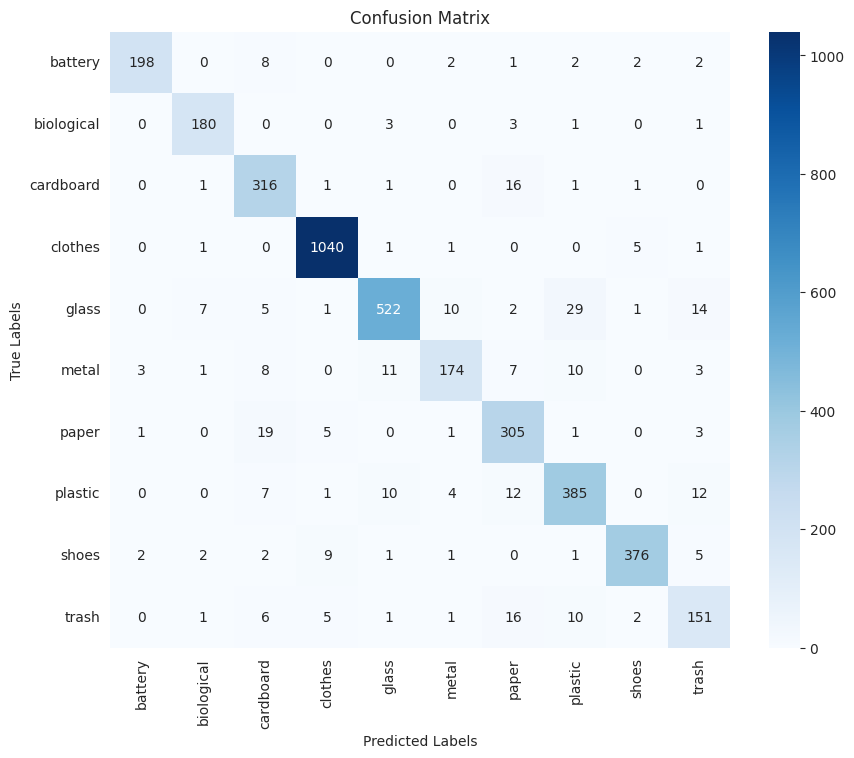

              precision    recall  f1-score   support

     battery       0.97      0.92      0.95       215
  biological       0.93      0.96      0.94       188
   cardboard       0.85      0.94      0.89       337
     clothes       0.98      0.99      0.99      1049
       glass       0.95      0.88      0.91       591
       metal       0.90      0.80      0.85       217
       paper       0.84      0.91      0.88       335
     plastic       0.88      0.89      0.88       431
       shoes       0.97      0.94      0.96       399
       trash       0.79      0.78      0.78       193

    accuracy                           0.92      3955
   macro avg       0.91      0.90      0.90      3955
weighted avg       0.92      0.92      0.92      3955



In [27]:
results = model1.evaluate(Test_generator)
print(f"Test Loss: {results[0]}, Test Acc: {results[1]}")

#Predict test set
y_pred = model1.predict(Test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

#True labels
y_true = Test_generator.classes

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

#Visualisasi
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=Test_generator.class_indices,
            yticklabels=Test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#Classification Report
print(classification_report(y_true, y_pred_classes, target_names=Test_generator.class_indices.keys()))

## Konversi Model

### Tensorflowjs

In [28]:
!pip install tensorflowjs

!tensorflowjs_converter \
  --input_format=keras \
  BestModel.h5 \
  modeltfjs/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-03 02:43:13.235420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746240193.255098    6140 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

### **TensorFlow Lite**

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

with open('model1.tflite', 'wb') as f:
  f.write(tflite_model)

# Label.txt
with open('labels.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

Saved artifact at '/tmp/tmp63wl0d_i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 225, 225, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137465420452432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420452816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420450512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420450320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420449552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420452624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420452048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420449936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420448592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420453008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420

### Saved Model

In [30]:
model1.export('saved_model/')

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 225, 225, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137465420452432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420452816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420450512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420450320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420449552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420452624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420452048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420449936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420448592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137465420453008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1374654204491

## Inference (Optional)